In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [285]:
import os
import datetime
import requests
import pandas as pd
from glob import glob
from bs4 import BeautifulSoup as bs

In [18]:
def dt(isodate):
    'Helper function to turn ISO date string into datetime object.'
    return datetime.datetime.strptime(isodate, '%Y-%m-%d')

In [93]:
def memeorandum_clusters(date, time='1200'):
    'Get clusters of Memeorandum news stories for a date (default is noon EST).'
    _url = 'https://www.memeorandum.com/{}/h{}'
    lnk = _url.format(date.strftime('%y%m%d'), time)
    r = requests.get(lnk)
    r.raise_for_status()
    s = bs(r.text)
    return s.find('div', {'class': 'nornbody'}).findAll('div', {'class': 'clus'})

In [131]:
def cluster_lead_data(clus):
    'Get data for the lead story in a cluster.'
    lead_headline = clus.find('div', {'class': 'ii'}).find('strong').text
    lead_link = clus.find('div', {'class': 'ii'}).find('strong').find('a')['href']
    lead_author = clus.find('cite').text.split('/')[0].strip().strip(':')
    lead_pub = clus.find('cite').find('a').text
    return lead_author, lead_pub, lead_headline, lead_link

In [168]:
def df_for_date(date):
    'Generate a data frame of lead news stories for specified date.'
    data = map(cluster_lead_data, memeorandum_clusters(date))
    df = pd.DataFrame(list(data), columns=['author', 'publication', 'headline', 'url'])
    df = df.reset_index().rename(columns={'index': 'rank'})
    df['rank'] = df['rank'] + 1
    df['date'] = date
    return df

In [289]:
for date in pd.date_range('2018-06-19', '2019-01-21'):
    outfile = 'data/{}.csv'.format(date.date().isoformat())
    if not os.path.exists(outfile):
        df_for_date(date).to_csv(outfile, encoding='utf8')

In [303]:
all_data = pd.concat(pd.read_csv(f, index_col=0, parse_dates=['date']) for f in glob('data/*.csv'))

In [304]:
lead_stories = all_data[all_data['rank'] <= 10]

In [305]:
lead_stories = lead_stories.set_index('date')

In [306]:
lead_stories['aoc'] = lead_stories.headline.str.lower().str.contains('ocasio-cortez')

In [307]:
lead_stories['aoc'].value_counts()

False    2131
True       15
Name: aoc, dtype: int64

In [309]:
lead_stories[lead_stories['aoc']]

,rank,author,publication,headline,url,aoc
date,,,,,,
2018-06-27,1,Vivian Wang,New York Times,Who Is Alexandria Ocasio-Cortez? A 28-Year-Ol...,http://www.nytimes.com/2018/06/27/nyregion/ale...,True
2018-07-11,2,Kenneth Lovett,New York Daily News,EXCLUSIVE: Ocasio-Cortez with another surprise...,http://www.nydailynews.com/news/politics/ny-po...,True
2018-07-12,9,Lisa W. Foderaro,New York Times,Ocasio-Cortez Highlights How Third-Party Quirk...,http://www.nytimes.com/2018/07/11/nyregion/oca...,True
2018-07-16,10,Ryan Grim,The Intercept,Ocasio-Cortez Floats a “Sub-Caucus” of Progres...,http://theintercept.com/2018/07/16/ocasio-cort...,True
2018-08-02,5,Hollywood Reporter,Hollywood Reporter,Is Alexandria Ocasio-Cortez Too Far Left for H...,http://www.hollywoodreporter.com/news/is-alexa...,True
2018-08-17,4,Christopher Barca,m.qchron.com,Ocasio-Cortez bans press from town hall,http://m.qchron.com/mobile/editions/queenswide...,True
2018-12-12,9,Matthew Yglesias,Vox,It's ridiculous that it's unconstitutional for...,http://www.vox.com/2018/12/12/18134945/alexand...,True
2018-12-18,9,Laura Barrón-López,Politico,Ocasio-Cortez weighs a new primary target: Hak...,http://www.politico.com/story/2018/12/18/ocasi...,True
2018-12-29,10,Chris Buskirk,American Greatness,It's Not That Alexandria Ocasio-Cortez Knows N...,http://amgreatness.com/2018/12/28/its-not-that...,True


/nix/store/hkgmx5kr4m0zbkyglnvyy13csws5x39l-python3.6-ipykernel-4.8.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


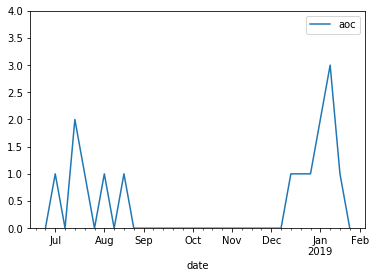

In [308]:
lead_stories.resample('W').agg({'aoc': lambda x: sum(1 if i else 0 for i in x)}).plot(ylim=(0,4));